# Inferring Grid Metrics
Modern general circulation models (GCMs) are usually constructed on different rectangular grids, commonly known as [five Arakawa grids](https://en.wikipedia.org/wiki/Arakawa_grids).  The `xgcm` package aim to provide a set of unified core interfaces for users to make grid-awared calculations such as finite difference `Grid.derivative`, interpolation `Grid.interp` and average `Grid.average` on these different grids.  These interfaces are also the building blocks for more complicated calculations such as higher-order derivatives.  Although `xgcm` tends to hide as many details of a grid as possible, **users are still encouraged to know their grid specifics** before using `xgcm`.

The most important concept in `xgcm` is the metrics which would be required for those core interfaces.  Each grid point has three kinds of fundamental metrics associated with it: **1D distance, 2D area and 3D volume** metrics.

The metrics are necessary for grid-awared calculation because they are in SI unit (m, m<sup>2</sup> and m<sup>3</sup> for distance, area, and volume respectively) while the raw grid coordinates may not (e.g., lat/lon coordinates).  Users who want to use `xgcm`'s interface may need to provide certain metrics explicitly.

**What does 'inferring Grid metrics' mean ?**

Standard GCM outputs generally contains certain kinds of the metrics, usually 1D distance metrics (e.g., `dx`, `dy`, `dz`).  However, some are missing for certain grid-awared operations.  One needs to reconstructing/inferring missing metrics using exsiting ones.  Hence **inferring Grid metrics** means:

1. First define the grid with available metrics;
2. Reconstruct missing metrics from existing output using `grid.interp`;
3. Redefine grid with those new metrics.

If you see `KeyError: "Unable to find any combinations of metrics for array dims {...} and axes (...)"`, then some metrics are probably missing in your `xgcm.Grid`.  This notebook will give some examples on how to provide required metrics, mostly based on a dataset output from [MITgcm](https://mitgcm.readthedocs.io/en/latest/).  Sometimes missing grid metrics can also be inferred (interpolated/reconstruct) from existing coordinates of the data.

---

## 1. Examples in the horizontal plane
First we load the example dataset (global ocean simulation at 4-degree resolution by MITgcm).  This is an [Arakawa C-grid](https://mitgcm.readthedocs.io/en/latest/algorithm/horiz-grid.html) dataset.  We need four kinds of variables: `UVEL` defined at U-point (`YC`, `XG`), `VVEL` at V-point (`YG`, `XC`), `DIVG` at tracer point (`YC`, `XC`) and `VORT` at zeta(vorticity)-point (`YG`, `XG`).  We drop out all irrelevant variables and then get the divergence and vorticity using [the method here](https://xgcm.readthedocs.io/en/latest/example_mitgcm.html).

In [1]:
import xarray as xr
import urllib.request
import shutil
from xgcm import Grid

# download the data
url = 'https://zenodo.org/record/4421428/files/'
file_name = 'mitgcm_example_dataset_v2.nc'
with urllib.request.urlopen(url + file_name) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
    
# open example dataset, select the horizontal slices
# drop some variables so that we only focus on UVEL and VVEL in the horizontal plane
ds = xr.open_dataset(file_name).isel(dict(Z=0,time=0)) \
                      .drop_vars(['Eta','PH','SALT','THETA','WVEL','Zl','time','iter'])

# Provide no metrics, only allow those operations that
# do not need metrics e.g., Grid.diff, Grid.interp...
grid = Grid(ds, periodic='X')

# Velocities should be explicitly weighted by metrics to get correct fluxes
ds['DIVG'] = (grid.diff(ds.UVEL * ds.dyG * ds.hFacW * ds.drF, 'X') +
              grid.diff(ds.VVEL * ds.dxG * ds.hFacS * ds.drF, 'Y', boundary='extend')) / ds.rA

ds['VORT'] = (grid.diff(ds.VVEL * ds.dyC, 'X') -
              grid.diff(ds.UVEL * ds.dxC, 'Y', boundary='extend')) / ds.rAz

print(ds)

<xarray.Dataset>
Dimensions:  (XC: 90, XG: 90, YC: 40, YG: 40)
Coordinates:
    maskC    (YC, XC) bool ...
    dyC      (YG, XC) float32 ...
    hFacC    (YC, XC) float32 ...
    rA       (YC, XC) float32 ...
    hFacS    (YG, XC) float32 ...
    Depth    (YC, XC) float32 ...
  * YG       (YG) float32 -80.0 -76.0 -72.0 -68.0 -64.0 ... 64.0 68.0 72.0 76.0
    Z        float32 -25.0
    PHrefC   float32 ...
    dyG      (YC, XG) float32 ...
    rAw      (YC, XG) float32 ...
    drF      float32 ...
  * YC       (YC) float32 -78.0 -74.0 -70.0 -66.0 -62.0 ... 66.0 70.0 74.0 78.0
    dxG      (YG, XC) float32 ...
  * XG       (XG) float32 0.0 4.0 8.0 12.0 16.0 ... 344.0 348.0 352.0 356.0
    maskW    (YC, XG) bool ...
    rAs      (YG, XC) float32 ...
    rAz      (YG, XG) float32 ...
    maskS    (YG, XC) bool ...
    dxC      (YC, XG) float32 ...
    hFacW    (YC, XG) float32 ...
  * XC       (XC) float32 2.0 6.0 10.0 14.0 18.0 ... 346.0 350.0 354.0 358.0
Data variables:
    UVEL     (YC,

### 1.1 1D metrics
Now the `ds` dataset contains a complete set of (four different) variables:

| variable names | grid point | dimensions |
| :---: | ----: | :---:  |
| UVEL  | u-point | (YC, XG) |
| VVEL  | v-point | (YG, XC) |
| DIVG  | tracer-point | (YC, XC) |
| VORT  | zeta-point | (YG, XG) |

To calculate the gradient of these variables using `Grid.derivative`, we need to provide necessary metrics，which is clearly shown in this figure:

<img src="https://mitgcm.readthedocs.io/en/latest/_images/hgrid-abcd.svg" width="40%">

Note that the dataset `ds` does not contain all the necessary 1D metrics, we can infer them **APPROXIMATELY** by interpolation.
<div class="alert alert-info">

*Note*: Interpolation of the metrics could lead to errors if the grid is very non-regular (e.g. near the poles) and it is always preferred to recover the metric from the model output if available.

</div>

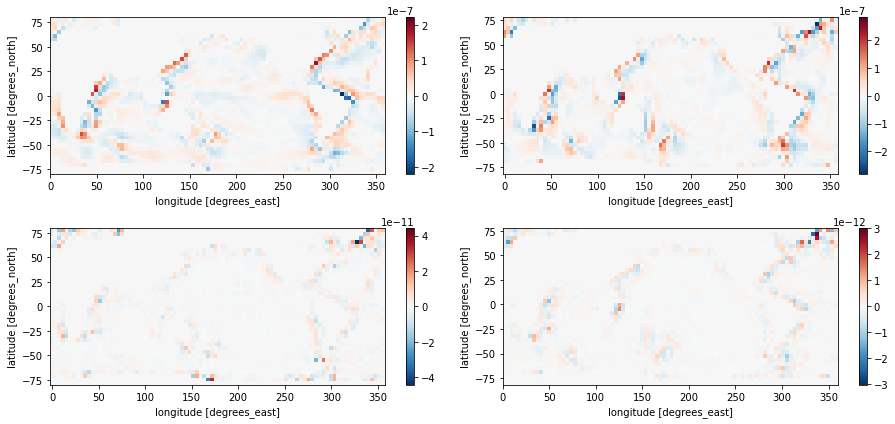

In [2]:
import matplotlib.pyplot as plt

UVEL = ds.UVEL
VVEL = ds.VVEL
DIVG = ds.DIVG
VORT = ds.VORT

# this is the missing 1D metrics, we infer
# them approximately by interpolation!
ds.coords['dxF'] = grid.interp(ds.dxC, 'X')
ds.coords['dxV'] = grid.interp(ds.dxG, 'X')

# provide all 1D X-metrics
metrics = {
    ('X',): ['dxC', 'dxG', 'dxF', 'dxV']} # 1D delta-X metrics

# pass in the metrics
grid = Grid(ds, periodic='X', metrics=metrics)

# no need to provide boundary condition because 'X' is periodic
duveldx = grid.derivative(UVEL, 'X') # need `dxF`
dvveldx = grid.derivative(VVEL, 'X') # need `dxV`
ddivgdx = grid.derivative(DIVG, 'X') # need `dxC`
dvortdx = grid.derivative(VORT, 'X') # need `dxG`

fig, ax = plt.subplots(2, 2, figsize=(13, 6))

duveldx.plot(ax=ax[0,0])
dvveldx.plot(ax=ax[0,1])
ddivgdx.plot(ax=ax[1,0])
dvortdx.plot(ax=ax[1,1])

plt.tight_layout()

If we do not provide, for example `dxV`, to the `Grid` object, it will raise an error like:

In [3]:
# do not provide `dxV`.
metrics = {
    ('X',) : ['dxC', 'dxG', 'dxF']} # 1D delta-X metrics, missing 'dxV'

# pass in the metrics
grid = Grid(ds, periodic='X', metrics=metrics)

# no need to provide boundary condition because 'X' is periodic
duveldx = grid.derivative(UVEL, 'X') # need `dxF`
dvveldx = grid.derivative(VVEL, 'X') # need `dxV`, raise error here
ddivgdx = grid.derivative(DIVG, 'X') # need `dxC`
dvortdx = grid.derivative(VORT, 'X') # need `dxG`

KeyError: "Unable to find any combinations of metrics for array dims {'XG', 'YG'} and axes ('X',)"

Similar for the y-derivative:

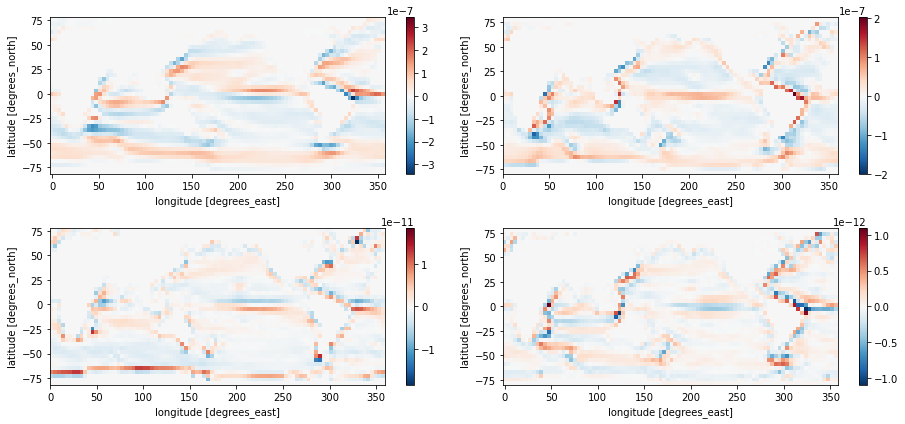

In [4]:
# this is the missing 1D metrics along Y, we infer
# them approximately by interpolation!
ds.coords['dyF'] = grid.interp(ds.dyC, 'Y', boundary='extend')
ds.coords['dyU'] = grid.interp(ds.dyG, 'Y', boundary='extend')

# provide all 1D y-metrics
metrics = {
    ('Y',) : ['dyC', 'dyG', 'dyF', 'dyU']} # 1D delta-Y metrics

# pass in the metrics
grid = Grid(ds, periodic='X', metrics=metrics)

# need Y-boundary condition
duveldy = grid.derivative(UVEL, 'Y', boundary='extend') # need `dyU`
dvveldy = grid.derivative(VVEL, 'Y', boundary='extend') # need `dyF`
ddivgdy = grid.derivative(DIVG, 'Y', boundary='extend') # need `dyC`
dvortdy = grid.derivative(VORT, 'Y', boundary='extend') # need `dyG`

fig, ax = plt.subplots(2, 2, figsize=(13, 6))

duveldy.plot(ax=ax[0,0])
dvveldy.plot(ax=ax[0,1])
ddivgdy.plot(ax=ax[1,0])
dvortdy.plot(ax=ax[1,1])

plt.tight_layout()

If we remove `dyG`, it also raise similar error as that in the x-direction:

In [5]:
# do not provide `dyG`.
metrics = {
    ('Y',) : ['dyC', 'dyF', 'dyU']} # 1D delta-Y metrics, missing `dyG`

# pass in the metrics
grid = Grid(ds, periodic='X', metrics=metrics)

# need Y-boundary condition
duveldy = grid.derivative(UVEL, 'Y', boundary='extend') # need `dyU`
dvveldy = grid.derivative(VVEL, 'Y', boundary='extend') # need `dyF`
ddivgdy = grid.derivative(DIVG, 'Y', boundary='extend') # need `dyC`
dvortdy = grid.derivative(VORT, 'Y', boundary='extend') # need `dyG`, raise error here

KeyError: "Unable to find any combinations of metrics for array dims {'XG', 'YC'} and axes ('Y',)"

### 1.2 2D metrics
Suppose that we need to calculate the area-weighted mean of a variable over the global, we need to choose proper 2D metrics.  Four kinds of variables need for four 2D metrics, according to the above [staggered-grid figure](https://mitgcm.readthedocs.io/en/latest/_images/hgrid-abcd.svg):

| variable names | grid point | dimensions | 2D metrics |
| :---: | ----: | :---:  | :---:  |
| UVEL  | u-point | (YC, XG) | rAw |
| VVEL  | v-point | (YG, XC) | rAs |
| DIVG  | tracer-point | (YC, XC) | rA |
| VORT  | zeta-point | (YG, XG) | rAz |

Here we just calculate the area-weighted mean using `xgcm.average` function, and compare it with non-weighted mean.

Calculating global mean of different variables are:

In [6]:
# Notice that right now we need this mask to properly maskout
# undefined values in both data and metrics
maskW = (UVEL != 0)
maskS = (VVEL != 0)
maskC = (DIVG != 0)
maskZ = (VORT != 0)

# maskout metrics
ds['rAw'] = ds['rAw'].where(maskW)
ds['rAs'] = ds['rAs'].where(maskS)
ds['rA' ] = ds['rA' ].where(maskC)
ds['rAz'] = ds['rAz'].where(maskZ)

metrics = {('X', 'Y'): ['rAw','rAs','rA','rAz']} # 2D area metrics

grid = Grid(ds, periodic='X', metrics=metrics)

uave_wei = grid.average(UVEL, ['X', 'Y']).values # need rAw
vave_wei = grid.average(VVEL, ['X', 'Y']).values # need rAs
dave_wei = grid.average(DIVG, ['X', 'Y']).values # need rA
zave_wei = grid.average(VORT, ['X', 'Y']).values # need rAz

uave = UVEL.where(maskW).mean(['YC','XG'], skipna=True).values
vave = VVEL.where(maskS).mean(['YG','XC'], skipna=True).values
dave = DIVG.where(maskC).mean(['YC','XC'], skipna=True).values
zave = VORT.where(maskZ).mean(['YG','XG'], skipna=True).values

print('        weighted means    vs    unweighted means')
print(' UVEL:    {0:.6e}              {1:.6e}'.format(uave_wei, uave))
print(' VVEL:    {0:.6e}              {1:.6e}'.format(vave_wei, vave))
print(' DIVG:    {0:.6e}              {1:.6e}'.format(dave_wei, dave))
print(' VORT:    {0:.6e}              {1:.6e}'.format(zave_wei, zave))

test grid.average
test grid.average
test grid.average
test grid.average
        weighted means    vs    unweighted means
 UVEL:    4.094419e-03              8.637649e-03
 VVEL:    4.158882e-03              5.595285e-03
 DIVG:    2.389945e-10              5.964250e-08
 VORT:    1.626648e-11              -1.907488e-09


Notice that the surface integral of divergence and vorticity over the global should be zero, which indicates the better results of the weighted average.  If we drop out `rAz`, it will raise similar error as before:

In [7]:
# do not provide `rAz`
metrics = {('X', 'Y'): ['rAw','rAs','rA']} # 2D area metrics missing `rAz`

grid = Grid(ds, periodic='X', metrics=metrics)

uave_wei = grid.average(UVEL, ['X', 'Y']).values # need rAw
vave_wei = grid.average(VVEL, ['X', 'Y']).values # need rAs
dave_wei = grid.average(DIVG, ['X', 'Y']).values # need rA
zave_wei = grid.average(VORT, ['X', 'Y']).values # need rAz, raise error here

test grid.average
test grid.average
test grid.average
test grid.average


KeyError: "Unable to find any combinations of metrics for array dims {'XG', 'YG'} and axes ['X', 'Y']"

If the model does not provide the 2D metrics, we can also infer them **APPROXIMATELY** using eight 1D metrics (`dxC`, `dxF`, `dxG`, `dxV`, `dyC`, `dyF`, `dyG`, `dyU`) as:

```python
rAw = ds.dxC * ds.dyG
rAs = ds.dxG * ds.dyC
rA  = ds.dxF * ds.dyF
rAz = ds.dxV * ds.dyU
```

This is only exact in Cartesian coordinates.  Here we add `rAz` back by **INFERRING** it as `rAzNew = ds.dxV * ds.dyU`:

In [8]:
ds.coords['rAzNew'] = (ds.dxV * ds.dyU).where(maskZ)

metrics = {('X', 'Y'): ['rAw','rAs','rA', 'rAzNew']} # provided with new rAz

grid = Grid(ds, periodic='X', metrics=metrics)

zave_wei = grid.average(VORT, ['X', 'Y']).values # need rAzNew

print('        weighted mean     vs    unweighted mean')
print(' VORT:    {0:.6e}              {1:.6e}'.format(zave_wei, zave))

test grid.average
        weighted mean     vs    unweighted mean
 VORT:    1.626682e-11              -1.907488e-09


Notice that the new weighted mean (1.169156e-11) here is not the same as previous one (1.626647e-11).  But it is small enough as compared to unweighted mean.  This indicates that it is an **approximation** of spherical area fractions by small rectangles and direct model-output 2D metrics are always prefered if available.

---

## 2. Examples in the x-z plane
For a simulation carried out in 2D x-z plane, here is a figure showing the vertical metrics:

<img src="https://mitgcm.readthedocs.io/en/latest/_images/vgrid-accur-center.svg" width="40%">

In this example, we only need the variables of `UVEL`, `WVEL` and `THETA`.

In [9]:
# re-open example dataset, select the x-z slices
ds = xr.open_dataset(file_name).isel(dict(YC=10,YG=10,time=0)) \
                      .drop_vars(['Eta','PH','SALT','VVEL','time','YG','iter','rA','rAw',
                                  'rAs','rAz','PHrefC','dyC','dyG','YC','maskS','hFacS'])

grid = Grid(ds, periodic='X') # simple grid without metrics

print(ds)

<xarray.Dataset>
Dimensions:  (XC: 90, XG: 90, Z: 15, Zl: 15)
Coordinates:
    maskC    (Z, XC) bool ...
    hFacC    (Z, XC) float32 ...
    Depth    (XC) float32 ...
  * Z        (Z) float32 -25.0 -85.0 -170.0 ... -3.575e+03 -4.19e+03 -4.855e+03
    drF      (Z) float32 ...
    dxG      (XC) float32 ...
  * XG       (XG) float32 0.0 4.0 8.0 12.0 16.0 ... 344.0 348.0 352.0 356.0
    maskW    (Z, XG) bool ...
  * Zl       (Zl) float32 0.0 -50.0 -120.0 ... -3.28e+03 -3.87e+03 -4.51e+03
    dxC      (XG) float32 ...
    hFacW    (Z, XG) float32 ...
  * XC       (XC) float32 2.0 6.0 10.0 14.0 18.0 ... 346.0 350.0 354.0 358.0
Data variables:
    UVEL     (Z, XG) float32 ...
    WVEL     (Zl, XC) float32 ...
    THETA    (Z, XC) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(extra_metadata=None, ll...


Here three variables, `UVEL`, `WVEL` and `THETA`, are respectively defined on U-point, W-point, and tracer-point.  To calculate the vertical derivatives using `Grid.derivative`, one need proper 1D vertical metrics.

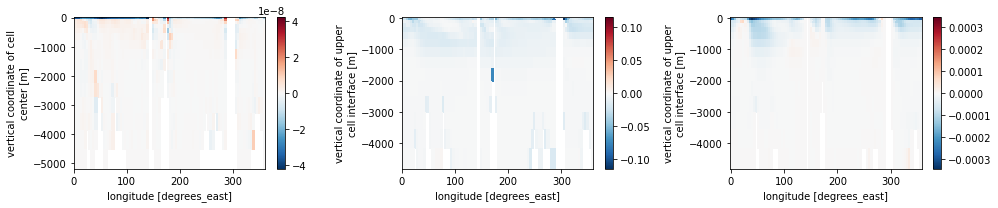

In [10]:
# this is only an approximation! Use model outputs if available. 
ds['drG'] = ds.hFacC * ds.drF
ds['drC'] = grid.interp(ds.drG, 'Z', boundary='extend')
ds['drW'] = grid.interp(ds.drC, 'X', boundary='extend')

metrics = {('Z',) : ['drC','drG','drW']} # 1D vertical metrics

grid = Grid(ds, periodic='X', metrics=metrics)

dwdz = grid.derivative(ds.WVEL , 'Z', boundary='extend') # need drG
dTdz = grid.derivative(ds.THETA, 'Z', boundary='extend') # need drC
dudz = grid.derivative(ds.UVEL , 'Z', boundary='extend') # need drW

fig, ax = plt.subplots(1, 3, figsize=(14, 3))

dwdz.plot(ax=ax[0])
dTdz.plot(ax=ax[1])
dudz.plot(ax=ax[2])

plt.tight_layout()

If we remove drC, it also raise similar error as that in the x-direction:

In [11]:
# remove `drC`
metrics = {('Z',) : ['drG','drW']} # 1D vertical metrics, missing `drC`

grid = Grid(ds, periodic='X', metrics=metrics)

dwdz = grid.derivative(ds.WVEL , 'Z', boundary='extend') # need drG
dTdz = grid.derivative(ds.THETA, 'Z', boundary='extend') # need drC, raise error here
dudz = grid.derivative(ds.UVEL , 'Z', boundary='extend') # need drW

KeyError: "Unable to find any combinations of metrics for array dims {'Zl', 'XC'} and axes ('Z',)"

---

## 3. Summary
For the MITgcm output defined on the Arakawa C grid, four kinds of grid points are defined (u-point, v-point, tracer-point and zeta-point).  As a result, 12 distance metrics, three sets of area metrics (4 per set), and four volume metrics can be summaried as:

```python
metrics = {
    ('X',): ['dxG', 'dxF', 'dxC', 'dxV'], # X distances
    ('Y',): ['dyG', 'dyF', 'dyC', 'dyU'], # Y distances
    ('Z',): ['drW', 'drS', 'drC', 'drF'], # Z distances
    
    ('X', 'Y'): ['rAw', 'rAs', 'rA', 'rAz'], # Areas in x-y plane
    ('X', 'Z'): ['yAw', 'yAc', 'yA', 'yAz'], # Areas in x-z plane
    ('Y', 'Z'): ['xAs', 'xAc', 'xA', 'xAz'], # Areas in y-z plane
    
    ('X', 'Y', 'Z'): ['volW', 'volS', 'volC', 'volZ']} # volume
```

Note the two area metrics `yAz` and `xAz` are defined at y- and x-components of vorticity points, which may be not be frequently used.  One may use this if they are interested in meridional overturning streamfunction or Walker circulation streamfunction.